In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
import sys

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
sys.path.append('/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/')
sys.path.append('/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF')
import Loader
import Metric

# 1. 학습
## 1-1. 데이터 로드

In [6]:
DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/data/preprocessed/'
loader = Loader.Loader(DIR, 4, 4)
loader.load_dataset()

(22709, 19140)

In [7]:
train = loader.formatting(0)
train_usr, train_prb, train_entry = shuffle(train[0], train[1], train[2])
train_usr = np.array(train_usr).reshape(-1,1)
train_prb = np.array(train_prb).reshape(-1,1)
train_entry = np.array(train_entry).reshape(-1,1)

In [8]:
valid_tr, valid_te  = loader.formatting(1)
valid_te_y, valid_te_X = valid_te
valid_tr_usr, valid_tr_prb, valid_tr_entry = shuffle(valid_tr[0], valid_tr[1], valid_tr[2])
valid_tr_usr = np.array(valid_tr_usr).reshape(-1,1)
valid_tr_prb = np.array(valid_tr_prb).reshape(-1,1)
valid_tr_entry = np.array(valid_tr_entry).reshape(-1,1)

In [9]:
test_tr, test_te  = loader.formatting(2)
test_te_y, test_te_X = test_te
test_tr_usr, test_tr_prb, test_tr_entry = shuffle(test_tr[0], test_tr[1], test_tr[2])
test_tr_usr = np.array(test_tr_usr).reshape(-1,1)
test_tr_prb = np.array(test_tr_prb).reshape(-1,1)
test_tr_entry = np.array(test_tr_entry).reshape(-1,1)

##1-2. 모델 학습

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd

class MF:
    def __init__(self, user_no, prob_no, useridx2level, probidx2level, K=4):
        # 변수
        self.user_no = user_no+5
        self.prob_no = prob_no
        self.useridx2level = useridx2level
        self.probidx2level = probidx2level
        self.K = K
        self.origin_userno = user_no
        self.free_now = 1

        # 레이어
        input_user = tf.keras.layers.Input(shape=(1,), dtype='int32') # 사용자 index 
        input_prob =  tf.keras.layers.Input(shape=(1,), dtype='int32') # 문제 index 
        embedding_user = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(user_no, K)(input_user)) # [사용자 index, 잠재요인]
        embedding_prob =  tf.keras.layers.Flatten()(tf.keras.layers.Embedding(prob_no, K)(input_prob)) # [문제 index, 잠재요인]
        matmul =  tf.keras.layers.Multiply()([embedding_user, embedding_prob]) # new [사용자 index, 문제 index]
        output =  tf.keras.layers.Dense(1)(matmul)

        # 모델
        self.model = tf.keras.Model(inputs=[input_user, input_prob], outputs=output)

    def train(self, model, train_usr, train_prb, train_entry, valid_tr_usr, valid_tr_prb, valid_tr_entry, valid_te_X, valid_te_y, cluster, epochs=100, batch_size=1024, k=30):
      train_N = len(train_usr)
      valid_tr_N = len(valid_tr_usr)
      valid_te_N = len(valid_te_X) 
      rc_vad = [] 
      hr_vad = []
      best_eval = 0.06428885953324527
      best_epoch = -1
      BESTMODEL_DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/best_model/cluster' + str(cluster)
      model = self.load_model(BESTMODEL_DIR)

      for epoch in range(4, epochs):
        ct, tr_loss, vad_loss = 0, 0, 0
        for i in range(0, train_N, batch_size):
          idxlist = range(i, min(i+batch_size, train_N-1))
          hist = self.model.fit([train_usr[idxlist], train_prb[idxlist]], train_entry[idxlist], verbose=0)
          ct+=1
          tr_loss += hist.history['loss'][-1]
        
        print("epoch[", epoch, "] train loss: ", tr_loss / ct)
        weights = self.model.get_weights()

        ct = 0
        for i in range(0, valid_tr_N, batch_size):
          idxlist = range(i, min(i+batch_size, valid_tr_N-1))
          hist = self.model.fit([valid_tr_usr[idxlist], valid_tr_prb[idxlist]], valid_tr_entry[idxlist],verbose=0)
          ct +=1
          vad_loss += hist.history['loss'][-1]
        
        print("epoch[", epoch, "] validation loss: ", vad_loss / ct)
        
        hit_rate = 0
        recall = []
        for i in range(0, valid_te_N):
          usr = valid_te_X.iloc[i,0]
          prbs = np.array(valid_te_X.iloc[i,1])
          usrs = np.array([usr]*len(prbs))
          valid_te_usr = usrs.reshape(-1,1)
          valid_te_prb = prbs.reshape(-1,1)

          pred = self.model.predict([valid_te_usr, valid_te_prb])
          pred = np.concatenate(pred).reshape(-1,1)
          filtered = self.level_filtering(valid_te_usr, valid_te_prb, pred, self.useridx2level, self.probidx2level, k)

          # valid_y
          heldout = np.array(valid_te_y.iloc[i,1])
          recall.append(Metric.recall_at_k(filtered[1], heldout, k))
          hit_rate += Metric.hit_rate_at_k(filtered[1], heldout, k)
          
        recall_ = np.mean(recall)
        hit_rate_ = hit_rate/valid_te_N
        
        self.model.set_weights(weights)
        
        if hit_rate_ > 0.30:
          break

        rc_vad.append(recall_)
        print("epoch[", epoch, "] recall: ", recall_)
        hr_vad.append(hit_rate_)
        print("epoch[", epoch, "] hit rate: ", hit_rate_)

        if hit_rate_ > best_eval:
          best_eval = hit_rate_
          best_epoch = epoch
          self.model.save(BESTMODEL_DIR)

      return rc_vad, hr_vad, best_eval, best_epoch
      

    def test(self, test_tr_usr, test_tr_prb, test_tr_entry, test_te_X, test_te_y, cluster, batch_size=1024, k=30):
      BESTMODEL_DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/best_model/cluster' + str(cluster)
      best_model = self.load_model(BESTMODEL_DIR)
      test_tr_N = len(test_tr_usr)
      test_te_N = len(test_te_X)
      test_hit_rate = 0
      test_recall = []
      
      for i in range(0, test_tr_N, batch_size):
          idxlist = range(i, min(i+batch_size, test_tr_N-1))
          self.model.fit([test_tr_usr[idxlist], test_tr_prb[idxlist]], test_tr_entry[idxlist], verbose=0)

      for i in range(0, test_te_N):
        usr = test_te_X.iloc[i,0]
        prbs = np.array(test_te_X.iloc[i,1])
        usrs = np.array([usr]*len(prbs))
        test_te_usr = usrs.reshape(-1,1)
        test_te_prb = prbs.reshape(-1,1)

        pred = self.model.predict([test_te_usr, test_te_prb])
        pred = np.concatenate(pred).reshape(-1,1)
        filtered = self.level_filtering(test_te_usr, test_te_prb, pred, self.useridx2level, self.probidx2level, k)

        heldout = np.array(test_te_y.iloc[i,1])
        test_recall.append(Metric.recall_at_k(filtered[1], heldout, k))
        test_hit_rate += Metric.hit_rate_at_k(filtered[1], heldout, k)

      recall = np.mean(test_recall)
      test_hit_rate = test_hit_rate/test_te_N

      return recall, test_hit_rate

    def get_model(self):
      return self.model

    def load_model(self, DIR):
      return tf.keras.models.load_model(DIR)

    def level_filtering(self, usr, prb, pred, userlevel_map, problevel_map, k):
      limit = min(k*10, len(pred)-1)
      usr = np.squeeze(usr)
      prb = np.squeeze(prb)
      pred = np.squeeze(pred)
      idx = np.argpartition(-pred, limit)[:limit]

      cdUser = usr[idx]
      cdProb = prb[idx]
      cdPred = pred[idx]

      problevel = np.array([problevel_map[p] for p in cdProb])
      maxlevel = np.array([userlevel_map[u] for u in cdUser]).astype('int64')
      lam = np.mean(cdPred)/100

      dist = np.abs(np.subtract(problevel,maxlevel))*lam
      cdPred = np.subtract(cdPred, dist)
              
      top_idx = np.argsort(-cdPred)[:k]
      top_k_data = (cdUser[top_idx], cdProb[top_idx], cdPred[top_idx])
      
      return top_k_data

In [11]:
def print_evaluation(vad, eval_type):
  plt.figure(figsize=(12, 3))
  plt.plot(vad)
  plt.ylabel("Validation " + eval_type + "@30")
  plt.xlabel("Epochs")

In [12]:
mf = MF(loader.users_no, loader.prob_no, loader.useridx2level, loader.probidx2level)
model = mf.get_model()

In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss='mse')

In [14]:
rc_vad, hr_vad, best_eval, best_epoch = mf.train(model, train_usr, train_prb, train_entry, valid_tr_usr, valid_tr_prb, valid_tr_entry, valid_te_X, valid_te_y, 4, epochs=100, batch_size=1024, k=30)

epoch[ 4 ] train loss:  0.1609153665390007
epoch[ 4 ] validation loss:  0.1613580672248147
epoch[ 4 ] recall:  0.0005885830692822094
epoch[ 4 ] hit rate:  0.04095112285336856
epoch[ 5 ] train loss:  0.16091237111750967
epoch[ 5 ] validation loss:  0.1613564643375112
epoch[ 5 ] recall:  0.0005687585463428275
epoch[ 5 ] hit rate:  0.04095112285336856
epoch[ 6 ] train loss:  0.16090969701704297
epoch[ 6 ] validation loss:  0.16135053766342614
epoch[ 6 ] recall:  0.0006937577335963233
epoch[ 6 ] hit rate:  0.04271246147071774
epoch[ 7 ] train loss:  0.16090173386715212
epoch[ 7 ] validation loss:  0.1613312733371228
epoch[ 7 ] recall:  0.0009711584950882113
epoch[ 7 ] hit rate:  0.052840158520475564
epoch[ 8 ] train loss:  0.16087066098646838
epoch[ 8 ] validation loss:  0.16123854963271203
epoch[ 8 ] recall:  0.0023132882541660907
epoch[ 8 ] hit rate:  0.08806693086745927
INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/best_model/cluster4

* epoch[ 0 ] train loss:  0.1609149750327998
* epoch[ 0 ] validation loss:  0.1613741118182656
* epoch[ 0 ] recall:  0.0007858974045234298
* epoch[ 0 ] hit rate:  0.05195948921180097
* INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/best_model/cluster4/assets
* epoch[ 1 ] train loss:  0.16091153480383696
* epoch[ 1 ] validation loss:  0.16136996842209728
* epoch[ 1 ] recall:  0.0007776693744451705
* epoch[ 1 ] hit rate:  0.05195948921180097
* epoch[ 2 ] train loss:  0.16090602865825773
* epoch[ 2 ] validation loss:  0.16135992340867203
* epoch[ 2 ] recall:  0.0010333629562374004
* epoch[ 2 ] hit rate:  0.059885512989872304
* INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/best_model/cluster4/assets
* epoch[ 3 ] train loss:  0.1608859262675271
* epoch[ 3 ] validation loss:  0.1613038656344305
* epoch[ 3 ] recall:  0.0012115028123289443
* epoch[ 3 ] hit rate:  0.06428885953324527
* INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/best_model/cluster4/assets[링크 텍스트](https://)

In [16]:
prev_recall = [0.0007858974045234298, 0.0007776693744451705, 0.0010333629562374004, 0.0012115028123289443]
prev_hitrate = [0.05195948921180097, 0.05195948921180097, 0.059885512989872304, 0.06428885953324527]
total_rc_vad = prev_recall + rc_vad
total_hr_vad = prev_hitrate + hr_vad

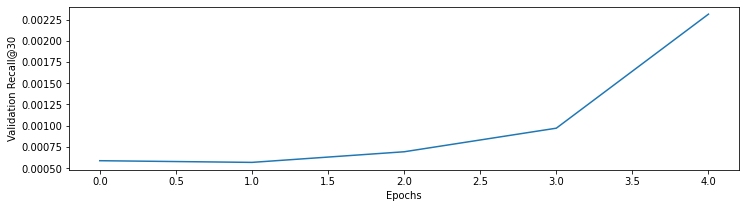

In [17]:
print_evaluation(rc_vad, "Recall")

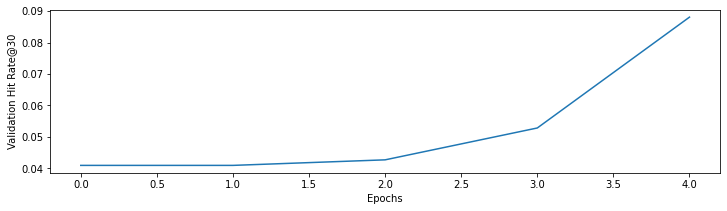

In [18]:
print_evaluation(hr_vad, "Hit Rate")

# 1-3. test

In [15]:
recall, test_hit_rate = mf.test(test_tr_usr, test_tr_prb, test_tr_entry, test_te_X, test_te_y, 4, batch_size=1024, k=30)
print("recall: ", recall)
print("hit rate: ", test_hit_rate)

recall:  0.038897310161491
hit rate:  0.5129898723029502
